In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

C:\Users\Admin\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir = './archive/training_set/'
test_dir = './archive/test_set/'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [3]:
class catdogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [4]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

In [6]:
cat_files_train = [tf for tf in os.listdir(train_dir+'/cats')]
dog_files_train = [tf for tf in os.listdir(train_dir+'/dogs')]

cat_files_test = [tf for tf in os.listdir(test_dir+'/cats')]
dog_files_test = [tf for tf in os.listdir(test_dir+'/dogs')]

cats_train = catdogDataset(cat_files_train, train_dir+'/cats', transform = data_transform)
dogs_train = catdogDataset(dog_files_train, train_dir+'/dogs', transform = data_transform)

catdogs_train = ConcatDataset([cats_train, dogs_train])

train_dloader = DataLoader(catdogs_train, batch_size = 32, shuffle=True, num_workers=0)


cats_test = catdogDataset(cat_files_test, test_dir+'/cats', transform = data_transform)
dogs_test = catdogDataset(dog_files_test, test_dir+'/dogs', transform = data_transform)

catdogs_test = ConcatDataset([cats_test, dogs_test])

test_dloader = DataLoader(catdogs_test, batch_size = 32, shuffle=True, num_workers=0)

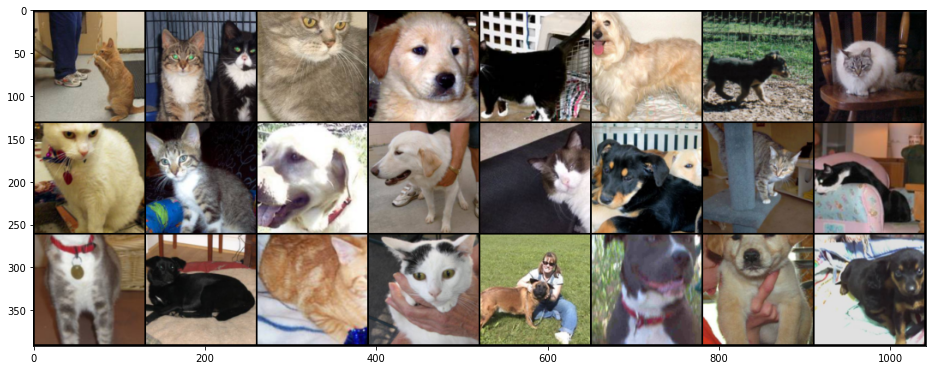

In [7]:
class_names = ['cat', 'dog']

samples, labels = iter(train_dloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()

In [8]:
class ConvResBlock(nn.Module):  # all the customized modules must be an extension (or children) of torch.nn.Module
    def __init__(self, in_channels, out_channels, kernel_size, activation=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        if activation:
            self.activate = nn.ReLU()  # relu activation
        else:
            self.activate = nn.Identity()  # do nothing: Identity(x) = x
    
    def forward(self, x):  # this function is the forward propagation (the function name must be forward)
        # add the residual after compute the convoluted results
        return self.activate(self.conv(x))

class ConvResModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resblock1 = ConvResBlock(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.resblock2 = ConvResBlock(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)
        self.flaten = nn.Flatten()
        self.map_to_output = nn.Sequential(
            nn.Linear(13456, 3364), nn.BatchNorm1d(3364), nn.ReLU(), nn.Linear(3364, 800), nn.BatchNorm1d(800), nn.ReLU(),
            nn.Linear(800, 400), nn.BatchNorm1d(400), nn.ReLU(), nn.Linear(400, 120), nn.BatchNorm1d(120), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(120, 84), nn.BatchNorm1d(84), nn.ReLU(), nn.Linear(84, 10), nn.BatchNorm1d(10), nn.ReLU(), 
            nn.Linear(10, 2),
        )
        
    def forward(self, x):  # forward pass
        x = self.pool1(self.resblock1(x))
        x = self.dropout1(x)
        x = self.pool2(self.resblock2(x))
        x = self.dropout2(x)
        #x = x.reshape(-1, 1) # replacement of nn.Flatten()
        x = self.flaten(x)
        return self.map_to_output(x)

In [9]:
model = ConvResModel()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
def train(target_epochs=10):
    num_train_samples = len(cat_files_train) + len(dog_files_train)
    num_test_samples = len(cat_files_test) + len(dog_files_test)
    lambda_ = 0.01  # L2 regulizer factor

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    print("train on ", num_train_samples, " samples, test on ", num_test_samples, " samples")
    for epoch in range(target_epochs):
        epoch_loss = 0
        num_corrects = 0
        # train
        model.train()  # switch the model to `train` mode
        for num_iter, (batch_x, labels) in enumerate(train_dloader):
            l2_loss = 0
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, labels)  # calculate the error
            
            # calculate l2 loss
            l2_loss = 0
            for p in model.parameters():
                l2_loss += p.pow(2).sum()
            total_loss = loss + lambda_ * l2_loss
            
            loss.backward()                 # back-propagation
            optimizer.step()                # update parameter using the gradient from the backpropagation

            # monitoring some metrics, note, l2_loss will not be monitored...
            # ...since it is just the regulizer for the parameters, not the actual metric of the AI model
            epoch_loss += loss.item()
            num_corrects += (output.argmax(dim=-1).eq(labels)).sum().item()

        train_loss.append(epoch_loss / (num_iter + 1))
        train_acc.append(num_corrects / num_train_samples)

        # validation. We don't learn anything here, so we don't need regulizer
        epoch_loss = 0
        num_corrects = 0
        model.eval()  # switch the model to `test` mode
        with torch.no_grad():  # since we don't need to do back propagation in test mode, we turn it off to save the memory
            for num_iter, (batch_x, labels) in enumerate(test_dloader):
                output = model(batch_x)
                loss = loss_fn(output, labels)
                epoch_loss += loss.item()
                num_corrects += (output.argmax(dim=-1).eq(labels)).sum().item()

        test_loss.append(epoch_loss / (num_iter + 1))
        test_acc.append(num_corrects / num_test_samples)

        # print metrics
        print(f"epoch: {epoch + 1}/{target_epochs} - loss: {train_loss[-1]:.4f} - accuracy: {train_acc[-1]:.4f}"
              f" - test_loss: {test_loss[-1]:.4f} - test_acc: {test_acc[-1]:.4f}")
    train_loss = np.array(train_loss)
    train_acc = np.array(train_acc)
    test_loss = np.array(test_loss)
    test_acc = np.array(test_acc)
    return train_loss, train_acc, test_loss, test_acc

In [12]:
train_loss, train_acc, test_loss, test_acc = train(10)

train on  8005  samples, test on  2023  samples
epoch: 1/10 - loss: 0.7003 - accuracy: 0.5454 - test_loss: 0.6804 - test_acc: 0.5650
epoch: 2/10 - loss: 0.6751 - accuracy: 0.5839 - test_loss: 0.6800 - test_acc: 0.5571
epoch: 3/10 - loss: 0.6691 - accuracy: 0.5858 - test_loss: 0.6902 - test_acc: 0.5096
epoch: 4/10 - loss: 0.6644 - accuracy: 0.5900 - test_loss: 0.6546 - test_acc: 0.6169
epoch: 5/10 - loss: 0.6529 - accuracy: 0.6149 - test_loss: 0.6442 - test_acc: 0.6223
epoch: 6/10 - loss: 0.6392 - accuracy: 0.6300 - test_loss: 0.6296 - test_acc: 0.6530
epoch: 7/10 - loss: 0.6286 - accuracy: 0.6481 - test_loss: 0.6292 - test_acc: 0.6396
epoch: 8/10 - loss: 0.6163 - accuracy: 0.6578 - test_loss: 0.6239 - test_acc: 0.6525
epoch: 9/10 - loss: 0.6115 - accuracy: 0.6660 - test_loss: 0.6143 - test_acc: 0.6495
epoch: 10/10 - loss: 0.6066 - accuracy: 0.6711 - test_loss: 0.6151 - test_acc: 0.6629
